# Bid PDF Extraction - Analysis

Exploratory analysis of extracted data from construction bid PDFs.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')
%matplotlib inline

/tmp/ipykernel_256849/3916844895.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load Extraction Results

In [2]:
# Load results
with open('../full_results.json', 'r') as f:
    data = json.load(f)

summary = data['summary']
results = data['results']

print(f"Total files processed: {summary['total_files']}")
print(f"Success rate: {summary['success_rate']}")

Total files processed: 100
Success rate: 96.0%


## Success Rate Analysis

In [3]:
# Document type distribution
doc_types = summary['by_document_type']
df_types = pd.DataFrame(doc_types).T

# Calculate success rate
df_types['success_rate'] = (df_types['successful'] / df_types['total'] * 100).round(1)

print(df_types)

                   total  successful  failed  success_rate
award_letter          28          28       0         100.0
bid_tabs              27          27       0         100.0
item_c_report         14          14       0         100.0
invitation_to_bid     27          27       0         100.0
bids_as_read           3           0       0           0.0
bid_summary            1           0       0           0.0


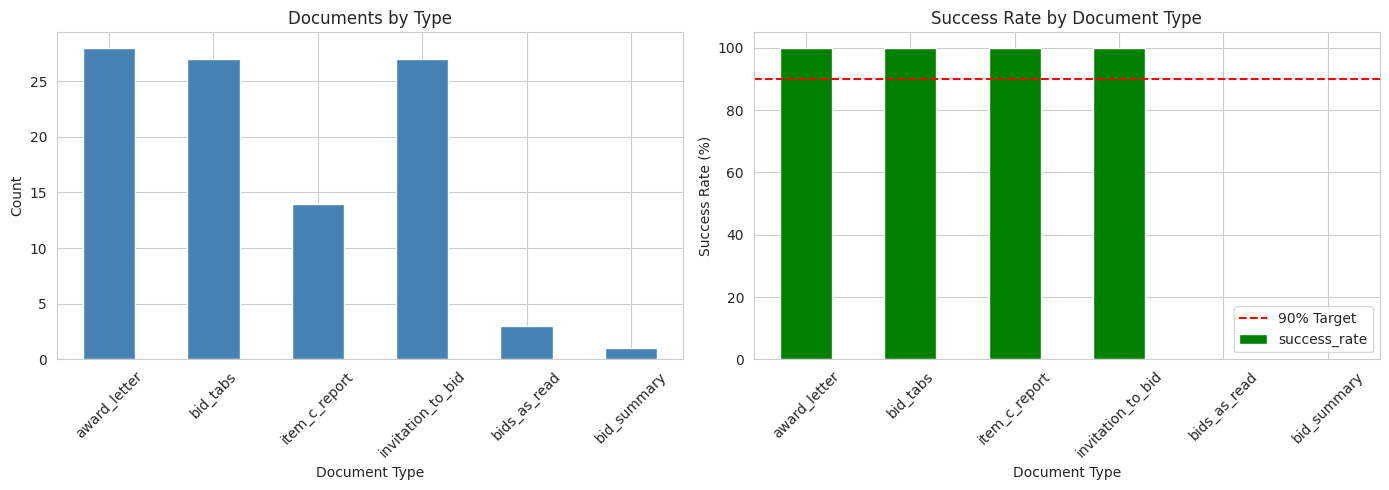

In [4]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Document type distribution
df_types['total'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Documents by Type')
axes[0].set_xlabel('Document Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Success rate by type
df_types['success_rate'].plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title('Success Rate by Document Type')
axes[1].set_xlabel('Document Type')
axes[1].set_ylabel('Success Rate (%)')
axes[1].axhline(y=90, color='r', linestyle='--', label='90% Target')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Processing Time Analysis

In [5]:
# Extract processing times
processing_data = []
for result in results:
    if 'metadata' in result and 'processing_time' in result['metadata']:
        processing_data.append({
            'document_type': result.get('document_type', 'unknown'),
            'processing_time': result['metadata']['processing_time'],
            'status': result.get('status', 'unknown')
        })

df_performance = pd.DataFrame(processing_data)

print("\nProcessing Time Statistics:")
print(df_performance.groupby('document_type')['processing_time'].describe())


Processing Time Statistics:


KeyError: 'document_type'

In [ ]:
# Processing time distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_performance, x='document_type', y='processing_time')
plt.title('Processing Time by Document Type')
plt.xlabel('Document Type')
plt.ylabel('Processing Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Data Completeness Analysis

In [ ]:
# Analyze data completeness
def calculate_completeness(data_dict):
    """Calculate percentage of non-null fields."""
    if not data_dict:
        return 0.0
    
    total = len(data_dict)
    filled = sum(1 for v in data_dict.values() if v is not None and v != "")
    return (filled / total * 100) if total > 0 else 0.0

completeness_data = []
for result in results:
    if result.get('status') == 'success' and 'data' in result:
        completeness = calculate_completeness(result['data'])
        completeness_data.append({
            'document_type': result.get('document_type', 'unknown'),
            'completeness': completeness,
            'file': Path(result['file_path']).name
        })

df_completeness = pd.DataFrame(completeness_data)

print("\nData Completeness by Document Type:")
print(df_completeness.groupby('document_type')['completeness'].describe())

In [ ]:
# Visualize completeness
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_completeness, x='document_type', y='completeness')
plt.title('Data Completeness Distribution by Document Type')
plt.xlabel('Document Type')
plt.ylabel('Completeness (%)')
plt.axhline(y=80, color='r', linestyle='--', label='80% Target')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Contract Data Analysis

In [ ]:
# Extract contract data
contracts = []
for result in results:
    if result.get('status') == 'success' and 'data' in result:
        data = result['data']
        if result.get('document_type') in ['invitation_to_bid', 'award_letter', 'item_c_report']:
            contracts.append({
                'contract_number': data.get('contract_number'),
                'awarded_amount': data.get('awarded_amount'),
                'estimated_cost': data.get('estimated_cost'),
                'document_type': result.get('document_type')
            })

df_contracts = pd.DataFrame(contracts)
df_contracts = df_contracts.dropna(subset=['contract_number'])

print(f"\nTotal unique contracts: {df_contracts['contract_number'].nunique()}")
print(f"\nContracts with award amounts: {df_contracts['awarded_amount'].notna().sum()}")
print(f"Contracts with estimates: {df_contracts['estimated_cost'].notna().sum()}")

In [ ]:
# Award amount distribution
awarded_contracts = df_contracts[df_contracts['awarded_amount'].notna()]

if len(awarded_contracts) > 0:
    plt.figure(figsize=(10, 6))
    plt.hist(awarded_contracts['awarded_amount'], bins=20, color='green', alpha=0.7)
    plt.title('Distribution of Contract Award Amounts')
    plt.xlabel('Award Amount ($)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    print(f"\nAward Amount Statistics:")
    print(f"Mean: ${awarded_contracts['awarded_amount'].mean():,.2f}")
    print(f"Median: ${awarded_contracts['awarded_amount'].median():,.2f}")
    print(f"Min: ${awarded_contracts['awarded_amount'].min():,.2f}")
    print(f"Max: ${awarded_contracts['awarded_amount'].max():,.2f}")

## Key Findings

Summary of analysis will be displayed here after running all cells.